# Tabular-playground-series-mar-2022

In this competition, you'll forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features give you the chance to model interactions across a network of roadways.

`Regression` task:
Metric is `mean absolute error`. 

For each `row_id` in the test set, you should predict a `congestion` measurement. 

1. `train.csv` - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.
* `row_id` - a unique identifier for this instance
* `time` - the 20-minute period in which each measurement was taken
* `x` - the east-west midpoint coordinate of the roadway
* `y` - the north-south midpoint coordinate of the roadway
* `direction` - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
* `congestion` - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.
2. `test.csv` - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.
3. `sample_submission.csv` - a sample submission file in the correct format

In [49]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os  # access to folder
from os import path
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

cwd = os.getcwd()
cwd = cwd.replace('\\','/')

train = pd.read_csv(cwd + "/tabular-playground-series-mar-2022/train.csv")
test = pd.read_csv(cwd + "/tabular-playground-series-mar-2022/test.csv")
sub = pd.read_csv(cwd + "/tabular-playground-series-mar-2022/sample_submission.csv")

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\nMemory usage: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum(), np.around(train.memory_usage().sum() / 1024**2), 2))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\nMemory usage: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum(), np.around(test.memory_usage().sum() / 1024**2, 3)))

# remove duplicates from train
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))
    
df_data = pd.concat([train_d, test])

Train Shape: (848835, 6)
Missing Data: 0
Duplicates: 0
Memory usage: 39.0

Test Shape: (2340, 5)
Missing Data: 0
Duplicates: 0
Memory usage: 0.089

No duplicates


In [50]:
train.head(2)

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49


In [51]:
test.head(2)

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB


In [52]:
sub.head(2)

,row_id,congestion
0,848835,0.0
1,848836,0.0


No missing data, No duplicates, data has not shuffled

In [53]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

# EDA

## Target

In [54]:
train['congestion'].describe()

count    848835.000000
mean         47.815305
std          16.799392
min           0.000000
25%          35.000000
50%          47.000000
75%          60.000000
max         100.000000
Name: congestion, dtype: float64

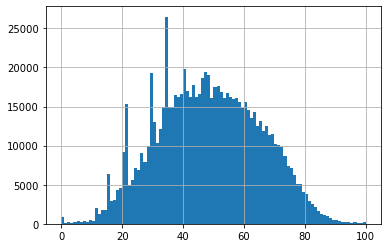

In [55]:
train['congestion'].hist(bins=100); # target value is normally distributed, but some outliers by the amount of observations

## X_train

In [56]:
train.dtypes

row_id         int64
time          object
x              int64
y              int64
direction     object
congestion     int64
dtype: object

In [57]:
train.describe()

,row_id,x,y,congestion
count,848835.00000,848835.000000,848835.000000,848835.000000
mean,424417.00000,1.138462,1.630769,47.815305
std,245037.70221,0.801478,1.089379,16.799392
min,0.00000,0.000000,0.000000,0.000000
25%,212208.50000,0.000000,1.000000,35.000000
50%,424417.00000,1.000000,2.000000,47.000000
75%,636625.50000,2.000000,3.000000,60.000000
max,848834.00000,2.000000,3.000000,100.000000


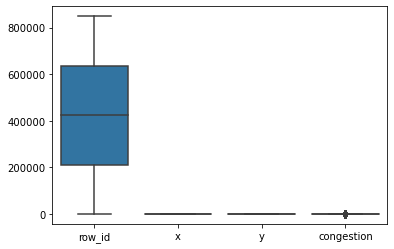

In [58]:
sns.boxplot(data=train);

In [59]:
# df_data['time'] = pd.to_datetime(df_data['time'], format='%Y-%m-%d %H:%M:%S')
# df_data['year'] = df_data.time.dt.year
# df_data['month'] = df_data.time.dt.month
# df_data['week'] = df_data.time.dt.isocalendar().week
# df_data['hour'] = df_data.time.dt.hour
# df_data['minute'] = df_data.time.dt.minute
# df_data['day_of_week'] = df_data.time.dt.day_name()
# df_data['day_of_year'] = df_data.time.dt.dayofyear
# df_data['is_weekend'] = (df_data.time.dt.dayofweek >= 5).astype("int")

# df_data.drop('time', axis=1, inplace=True)

In [60]:
# from itertools import cycle
# from plotly.subplots import make_subplots

# palette = cycle(px.colors.sequential.Sunsetdark)
# df_graph = df_data[df_data['congestion'].isnull() == False]

# # chart
# fig = make_subplots(rows=2, cols=3, 
#                     specs=[[{"type": "scatter"}, {"type": "scatter"}, {'type':'scatter'}], [{"type": "scatter"}, {"type": "scatter"}, {'type':'scatter'}]],
#                     column_widths=[0.33, 0.33, 0.34], vertical_spacing=0.125, horizontal_spacing=0.1,
#                     subplot_titles=("Monday Congestion", "Tuesday Congestion", "Wednesday Congestion",'Thursday Congestion','Friday Congestion','Weekend Congestion'))

# # Upper Left chart
# df_monday = df_graph[df_graph.day_of_week == 'Monday'].groupby(['hour']).agg({"congestion" : "mean"}).reset_index()
# fig.add_trace(go.Scatter(x=df_monday['hour'], y=df_monday['congestion'], mode='lines+markers',
#                  marker = dict(color = next(palette)), name='Monday Congestion'), row = 1, col = 1)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=1)
# fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.5, linecolor='gray',linewidth=2, row=1, col=1)

# # Upper Medium chart
# df_tuesday = df_graph[df_graph.day_of_week == 'Tuesday'].groupby(['hour']).agg({"congestion" : "mean"}).reset_index()
# fig.add_trace(go.Scatter(x=df_tuesday['hour'], y=df_tuesday['congestion'], mode='lines+markers',
#                  marker = dict(color = next(palette)), name='Monday Congestion'), row = 1, col = 2)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=2)
# fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.5, linecolor='gray',linewidth=2, row=1, col=2)

# # Upper Right chart
# df_wednesday = df_graph[df_graph.day_of_week == 'Wednesday'].groupby(['hour']).agg({"congestion" : "mean"}).reset_index()
# fig.add_trace(go.Scatter(x=df_wednesday['hour'], y=df_wednesday['congestion'], mode='lines+markers',
#                  marker = dict(color = next(palette)), name='Monday Congestion'), row = 1, col = 3)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=3)
# fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.5, linecolor='gray',linewidth=2, row=1, col=3)

# # Bottom Left chart
# df_thursday = df_graph[df_graph.day_of_week == 'Thursday'].groupby(['hour']).agg({"congestion" : "mean"}).reset_index()
# fig.add_trace(go.Scatter(x=df_thursday['hour'], y=df_thursday['congestion'], mode='lines+markers',
#                  marker = dict(color = next(palette)), name='Monday Congestion'), row = 2, col = 1)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=2, col=1)
# fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.5, linecolor='gray',linewidth=2, row=2, col=1)

# # Bottom Medium chart
# df_friday = df_graph[df_graph.day_of_week == 'Friday'].groupby(['hour']).agg({"congestion" : "mean"}).reset_index()
# fig.add_trace(go.Scatter(x=df_friday['hour'], y=df_friday['congestion'], mode='lines+markers',
#                  marker = dict(color = next(palette)), name='Monday Congestion'), row = 2, col = 2)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=2, col=2)
# fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.5, linecolor='gray',linewidth=2, row=2, col=2)

# # Bottom Right chart
# df_weekend = df_graph[df_graph.is_weekend == True].groupby(['hour']).agg({"congestion" : "mean"}).reset_index()
# df_saturday = df_graph[df_graph.day_of_week == 'Saturday'].groupby(['hour']).agg({"congestion" : "mean"}).reset_index()
# df_sunday = df_graph[df_graph.day_of_week == 'Sunday'].groupby(['hour']).agg({"congestion" : "mean"}).reset_index()

# fig.add_trace(go.Scatter(x=df_weekend['hour'], y=df_weekend['congestion'], mode='lines+markers',
#                  marker = dict(color = next(palette)), name='Weekend Average Congestion'), row = 2, col = 3)
# fig.add_trace(go.Scatter(x=df_saturday['hour'], y=df_saturday['congestion'], mode='lines+markers',
#                  marker = dict(color = next(palette)), name='Saturday Congestion'), row = 2, col = 3)
# fig.add_trace(go.Scatter(x=df_sunday['hour'], y=df_sunday['congestion'], mode='lines+markers',
#                  marker = dict(color = next(palette)), name='Sunday Congestion'), row = 2, col = 3)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=2, col=3)
# fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.5, linecolor='gray',linewidth=2, row=2, col=3)

# # General Styling
# fig.update_layout(height=750, bargap=0.2,
#                   margin=dict(b=50,r=30,l=100),
#                   title_text="Day of Week Congestion Analysis",
#                   #template="plotly_dark",
#                   paper_bgcolor="#303330",
#                   plot_bgcolor = "#303330",
#                   title_font=dict(size=29, color='floralwhite', family="Lato, sans-serif"),
#                   font=dict(color='floralwhite'), 
#                   hoverlabel=dict(bgcolor="floralwhite", font_size=13, font_family="Lato, sans-serif"),
#                   showlegend=False)

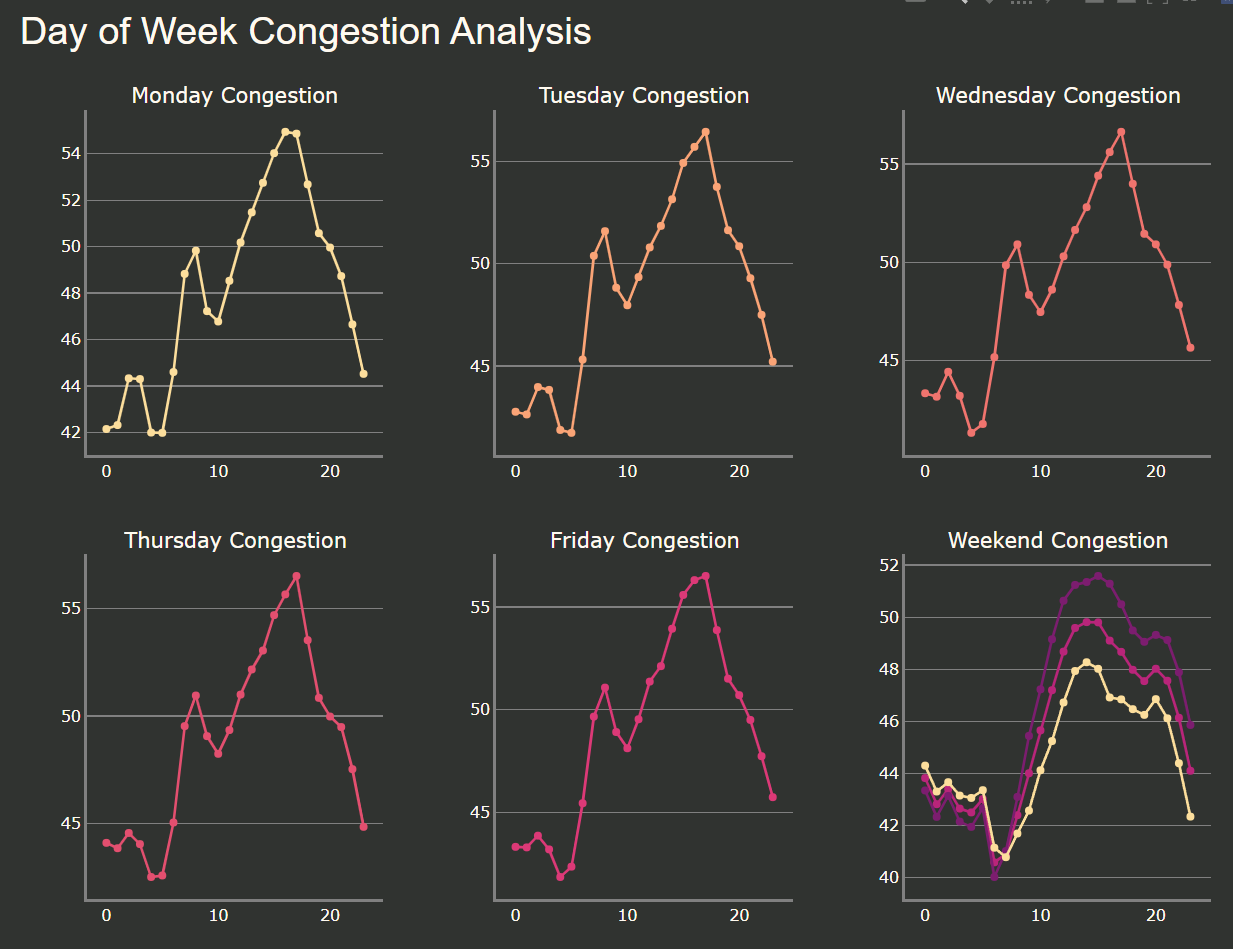

In [61]:
# palette = cycle(px.colors.sequential.Sunsetdark)
# df_graph = df_data[df_data['congestion'].isnull() == False]

# # chart
# fig = make_subplots(rows=1, cols=3, 
#                     specs=[[{"type": "bar"}, {"type": "bar"}, {'type':'bar'}]],
#                     column_widths=[0.33, 0.34, 0.33], vertical_spacing=0.1, horizontal_spacing=0.1,
#                     subplot_titles=("Mean Congestion per Direction", "Mean Congestion Per X Location", "Mean Congestion per Y Location"))

# # Left chart
# df_direction = df_graph.groupby(['direction']).agg({"congestion" : "mean"})
# values = list(range(8))
# fig.add_trace(go.Bar(x=df_direction.index, y=df_direction['congestion'], marker = dict(color=values, colorscale="Sunsetdark"), name = 'Day of Week'),
#                       row=1, col=1)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=1)
# fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=1, col=1)

# # Middle chart
# df_x = df_graph.groupby(['x']).agg({"congestion" : "mean"})
# values = list(range(3))
# fig.add_trace(go.Bar(x=df_x.index, y=df_x['congestion'], marker = dict(color=values, colorscale="Sunsetdark"), name = 'Day of Week'),
#                       row=1, col=2)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=2)
# fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=1, col=2)

# # Right chart
# df_y = df_graph.groupby(['y']).agg({"congestion" : "mean"})
# values = list(range(4))
# fig.add_trace(go.Bar(x=df_y.index, y=df_y['congestion'], marker = dict(color=values, colorscale="Sunsetdark"), name = 'Day of Week'),
#                       row=1, col=3)

# fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=3)
# fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=1, col=3)

# # General Styling
# fig.update_layout(height=400, bargap=0.2,
#                   margin=dict(b=50,r=30,l=100),
#                   title_text="Direction and Location Analysis",
#                   #template="plotly_dark",
#                   paper_bgcolor="#303330",
#                   plot_bgcolor = "#303330",
#                   title_font=dict(size=29, color='floralwhite', family="Lato, sans-serif"),
#                   font=dict(color='floralwhite'), 
#                   hoverlabel=dict(bgcolor="floralwhite", font_size=13, font_family="Lato, sans-serif"),
#                   showlegend=False)

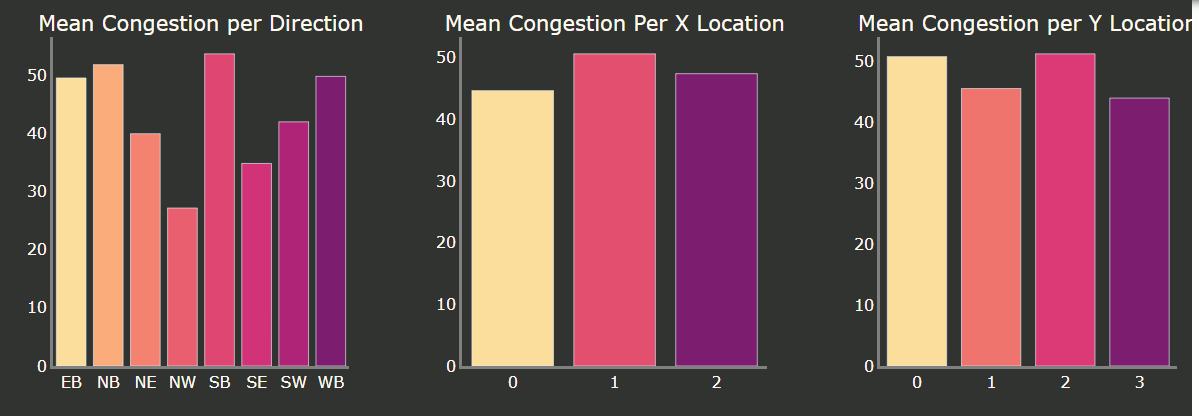

### Outliers

Outlier is an observation that is numerically distant from the rest of the data or in a simple word it is the value which is out of the range.let’s take an example to check what happens to a data set with and data set without outliers.

**Grubbs Test:** 

Grubbs' test is defined for the hypothesis: `Ho`: **There are no outliers in the data set** 
`H1`: **There is exactly one outlier in the data set** 

In [62]:
# import scipy.stats as stats
# def grubbs_test(x):
#     n = len(x)
#     mean_x = np.mean(x)
#     sd_x = np.std(x)
#     numerator = max(abs(x-mean_x))
#     g_calculated = numerator/sd_x
#     print("Grubbs Calculated Value:",g_calculated)
#     t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
#     g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
#     print("Grubbs Critical Value:",g_critical)
#     if g_critical > g_calculated:
#         print("From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers\n")
#     else:
#         print("From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers\n")

# grubbs_test(df_data[df_data.congestion.isnull() == False]['congestion'])

**Z-score:**

In [63]:
# df_outlier = df_data.reset_index().set_index('row_id').copy()
# out=[]
# def Zscore_outlier(df):
#     m = np.mean(df)
#     sd = np.std(df)
#     row = 0
#     for i in df: 
#         z = (i-m)/sd
#         if np.abs(z) > 3: 
#             out.append(row)
#         row += 1
#     return out

# outliers_index = Zscore_outlier(df_outlier[df_outlier.congestion.isnull() == False]['congestion'])

In [64]:
# df_outlier['outlier'] = 0
# df_outlier.loc[outliers_index,'outlier'] = 1

# fig = px.scatter(df_outlier, x=df_outlier.index, y='congestion', color = 'outlier')
# fig.update_xaxes(visible = False, zeroline = False)
# fig.update_yaxes(showgrid = True, gridcolor = 'gray', gridwidth = .5, zeroline = False)

# fig.update_layout(height=400,
#                   margin=dict(b=20,r=20,l=20,t=70),
#                   title_text="Congestion Outliers Analysis",
#                   paper_bgcolor="#303330",
#                   plot_bgcolor = "#303330",
#                   title_font=dict(size=29, color='floralwhite', family="Lato, sans-serif"),
#                   font=dict(color='floralwhite'), 
#                   hoverlabel=dict(bgcolor="floralwhite", font_size=13, font_family="Lato, sans-serif"))

# Baseline

**1-st baseline = -7.21775 MAE**

In [65]:
def baseline(X, y):
    from sklearn.model_selection import cross_val_score
    X = reduce_mem_usage(X)
    model = RandomForestRegressor()
    cv = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
    )
    score = cv.mean()
    print(f"Baseline score: {score:.5f} MAE")
    return score
    


train_base = df_data[df_data.congestion.isnull() == False].copy()
train_base['time'] = pd.to_datetime(train_base['time'], format='%Y-%m-%d %H:%M:%S')
train_base['year'] = train_base.time.dt.year
train_base['month'] = train_base.time.dt.month
train_base['week'] = train_base.time.dt.isocalendar().week
train_base['hour'] = train_base.time.dt.hour
train_base['minute'] = train_base.time.dt.minute
train_base['day_of_week'] = train_base.time.dt.day_name()
train_base['day_of_year'] = train_base.time.dt.dayofyear
train_base['is_weekend'] = (train_base.time.dt.dayofweek >= 5).astype("int")
train_base.drop('time', axis=1, inplace=True)


train_base.drop('row_id', axis=1, inplace=True)
train_base.drop('year', axis=1, inplace=True)
train_base['direction'] = train_base['direction'].map({'EB': 0, 'NB': 1, 'SB': 2, 'WB': 3, 'NE': 4, 'SW': 5, 'NW': 6, 'SE': 7})
train_base['day_of_week'] = train_base['day_of_week'].map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6})
# y = train_base['congestion']
# X = train_base.drop('congestion', axis=1)

# baseline_score = baseline(train_base.drop('congestion', axis=1), train_base['congestion'])
# print(f"Baseline score: {baseline_score:.5f} MAE")

In [66]:
# from pycaret.regression import *

# train_base.drop('week', axis=1, inplace=True)

# s = setup(data = train_base,
#           target = 'congestion',
#           fold = 2,
#           fold_shuffle = True)

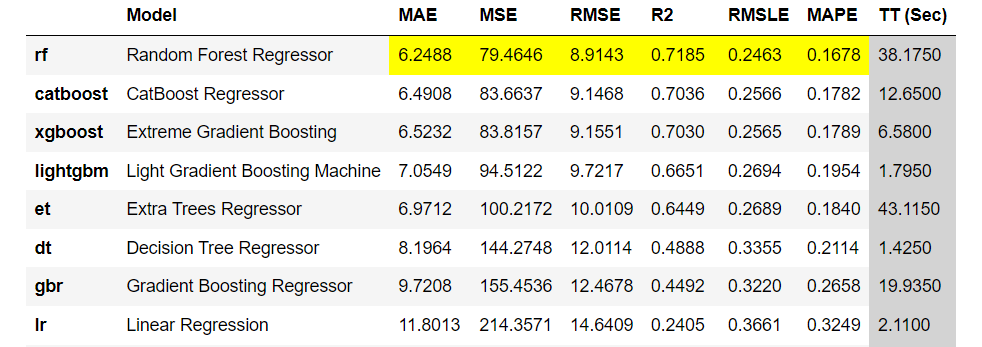

In [67]:
# best_model = compare_models(exclude=['knn'])

# FE

In [68]:
stop

NameError: name 'stop' is not defined

In [69]:
# remove row_id and year(the same year for train & test)
df_data['time'] = pd.to_datetime(df_data['time'], format='%Y-%m-%d %H:%M:%S')
df_data['year'] = df_data.time.dt.year
df_data['month'] = df_data.time.dt.month
df_data['week'] = df_data.time.dt.isocalendar().week
df_data['hour'] = df_data.time.dt.hour
df_data['minute'] = df_data.time.dt.minute
df_data['day_of_week'] = df_data.time.dt.day_name()
df_data['day_of_year'] = df_data.time.dt.dayofyear
df_data['is_weekend'] = (df_data.time.dt.dayofweek >= 5).astype("int")
df_data['is_month_start'] = df_data['time'].dt.is_month_start.astype('int')
df_data['is_month_end'] = df_data['time'].dt.is_month_end.astype('int')
df_data['hour+minute'] = df_data['time'].dt.hour * 60 + df_data['time'].dt.minute
df_data['is_weekend'] = (df_data['time'].dt.dayofweek > 4).astype('int')
df_data['is_afternoon'] = (df_data['time'].dt.hour > 12).astype('int')

df_data.drop('time', axis=1, inplace=True)
df_data.drop('row_id', axis=1, inplace=True)
df_data.drop('year', axis=1, inplace=True)
df_data.drop('week', axis=1, inplace=True)
df_data.drop('day_of_week', axis=1, inplace=True)

df_data['x+y'] = df_data['x'].astype('str') + df_data['y'].astype('str')
df_data['x+y+direction'] = df_data['x'].astype('str') + df_data['y'].astype('str') + df_data['direction'].astype('str')
df_data['hour+direction'] = df_data['hour'].astype('str') + df_data['direction'].astype('str')
df_data['hour+x+y'] = df_data['hour'].astype('str') + df_data['x'].astype('str') + df_data['y'].astype('str')
df_data['hour+direction+x'] = df_data['hour'].astype('str') + df_data['direction'].astype('str') + df_data['x'].astype('str')
df_data['hour+direction+y'] = df_data['hour'].astype('str') + df_data['direction'].astype('str') + df_data['y'].astype('str')
df_data['hour+direction+x+y'] = df_data['hour'].astype('str') +df_data['direction'].astype('str') + df_data['x'].astype('str') + df_data['y'].astype('str')
df_data['hour+x'] = df_data['hour'].astype('str') + df_data['x'].astype('str')
df_data['hour+y'] = df_data['hour'].astype('str') + df_data['y'].astype('str')
# cycling
from math import sin, cos, pi, exp
sin_vals = {
    'NB': 0.0,
    'NE': sin(1 * pi/4),
    'EB': 1.0,
    'SE': sin(3 * pi/4),
    'SB': 0.0,
    'SW': sin(5 * pi/4),    
    'WB': -1.0,    
    'NW': sin(7 * pi/4),  
}
cos_vals = {
    'NB': 1.0,
    'NE': cos(1 * pi/4),
    'EB': 0.0,
    'SE': cos(3 * pi/4),
    'SB': -1.0,
    'SW': cos(5 * pi/4),    
    'WB': 0.0,    
    'NW': cos(7 * pi/4),  
}
df_data['sin'] = df_data['direction'].map(sin_vals)
df_data['cos'] = df_data['direction'].map(cos_vals)
# baseline score = -7.20654MAE

# combine direction and location
df_data['roadway'] = df_data.x.astype(str) + df_data.y.astype(str) + df_data.direction.astype(str)

# maths trainsformations
df_data['x_cos_hour'] = df_data.x * df_data.cos * df_data.hour
df_data['y_sen_hour'] = df_data.y * df_data.sin * df_data.hour
df_data = df_data.drop(['x','y','direction'], axis=1)
# # px.box(df_data[df_data.congestion.isnull() == False], x="roadway", y="congestion", color = 'roadway')

# # Mean, median, maximum, minimum congestion per roadway / time
keys = ['roadway','hour', 'minute']
df = df_data.groupby(by=keys).mean().reset_index().set_index(keys)
df['mean congestion'] = df['congestion']
df_data = df_data.merge(df['mean congestion'], how='left', left_on=keys, right_on=keys)

df = df_data.groupby(by=keys).median().reset_index().set_index(keys)
df['median congestion'] = df['congestion']
df_data = df_data.merge(df['median congestion'], how='left', left_on=keys, right_on=keys)

df = df_data.groupby(by=keys).min().reset_index().set_index(keys)
df['min congestion'] = df['congestion']
df_data = df_data.merge(df['min congestion'], how='left', left_on=keys, right_on=keys)

df = df_data.groupby(by=keys).max().reset_index().set_index(keys)
df['max congestion'] = df['congestion']
df_data = df_data.merge(df['max congestion'], how='left', left_on=keys, right_on=keys)

from catboost import CatBoostRegressor
model = CatBoostRegressor(task_type="GPU",devices='0:1', loss_function='MAE', verbose=False)
# mean congestion
X = df_data[df_data.congestion.isnull() == False][['mean congestion']]
y = df_data[df_data.congestion.isnull() == False]['congestion']
model.fit(X, y)
y_preds = model.predict(df_data[['mean congestion']])
df_data['meancongestion_preds'] = y_preds

# from math import *
# # df_data['sin_meancongestion']=df_data.apply(lambda x: sin(x['mean congestion']),axis=1)
# df_data['root_meancongestion']=df_data.apply(lambda x: sqrt(x['mean congestion']),axis=1)
# # df_data['log_meancongestion']=df_data.apply(lambda x: np.log2(x['mean congestion']),axis=1)

In [ ]:
# df_data.head(10)

In [ ]:
# df_data.loc[(df_data['congestion'] >= 20) & (df_data['congestion'] <= 40)]

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# qualitative = [col for col in df_data if df_data[col].dtype == 'object']
# for feature in qualitative:
#     df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!memory reduction    
# df_data = reduce_mem_usage(df_data)

# # rely on mutual information remove columns
# #df_data = df_data.drop(['month','minute','is_weekend','day_of_year','cos','sin'],axis=1)
# df_train = df_data[df_data.congestion.isnull() == False]

# df_test = df_data[df_data.congestion.isnull() == True]
# df_test = df_test.drop(['congestion'],axis=1)

# X = df_train.drop('congestion', axis=1)
# y = df_train['congestion']

## Mutual Information

The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

In [ ]:
# # see best parameters by mutial information
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBRegressor

# def make_mi_scores(X, y):
#     X = X.copy()
#     for colname in X.select_dtypes(["object"]):
#         X[colname], _ = X[colname].factorize()
#     # All discrete features should now have integer dtypes
#     #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
#     mi_scores = mutual_info_regression(X, y, random_state=0)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# y = df_data[df_data['congestion'].isnull() == False]['congestion']
# x = df_data[df_data['congestion'].isnull() == False].drop('congestion', axis=1)
# mi_scores = make_mi_scores(x, y)
# mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'index':'Feature'})

In [ ]:
# fig = px.bar(mi_scores, x='MI Scores', y='Feature', color="MI Scores",
#              color_continuous_scale='darkmint')
# fig.update_layout(height = 750, title_text="Mutual Information Scores",
#                   title_font=dict(size=29, family="Lato, sans-serif"), xaxis={'categoryorder':'category ascending'}, margin=dict(t=80))

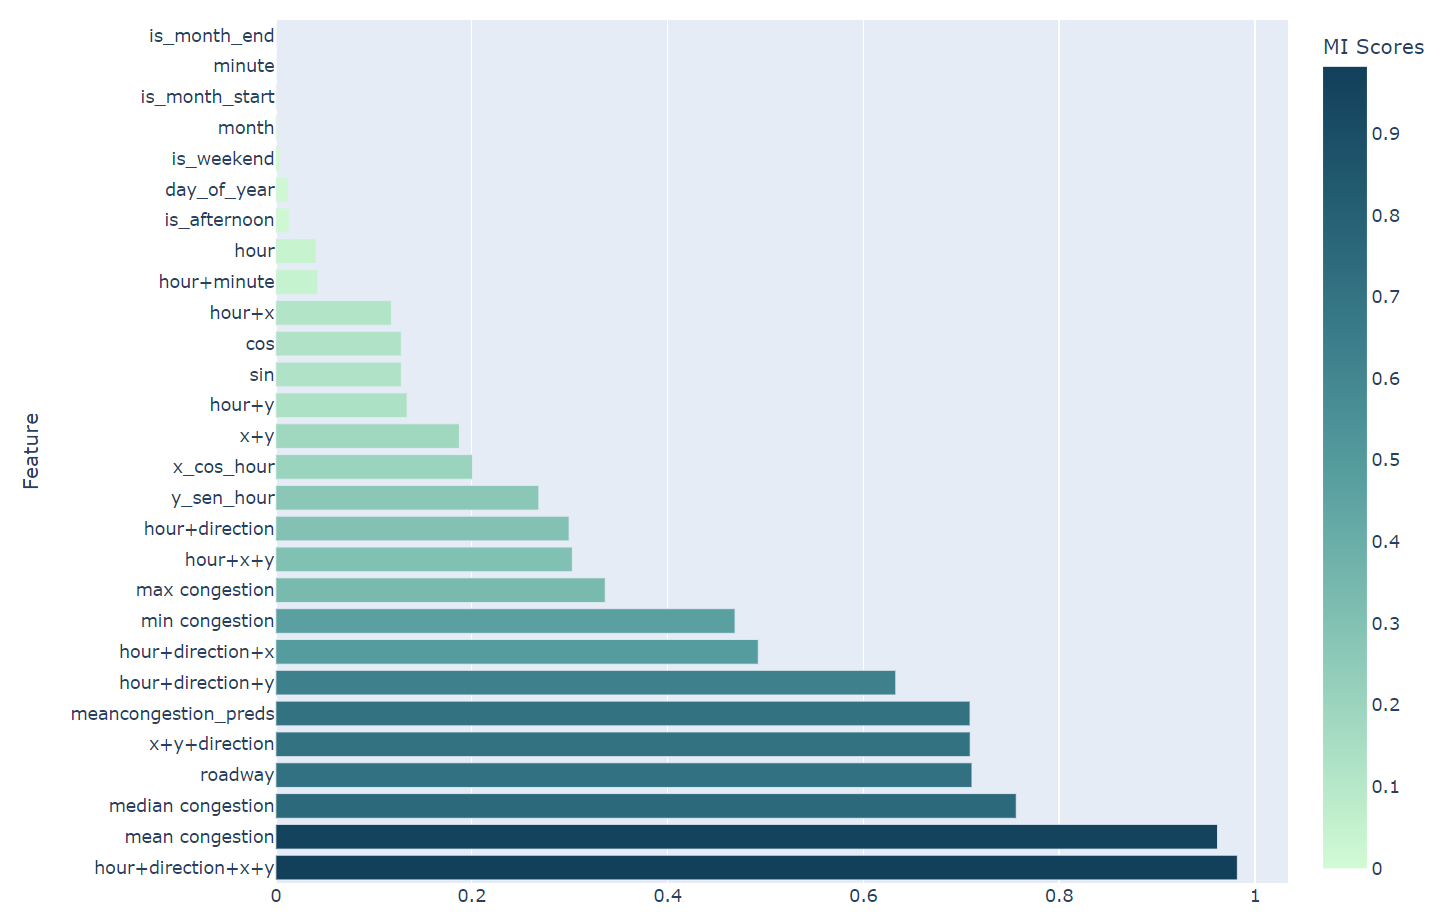

In [70]:
from sklearn.preprocessing import LabelEncoder
qualitative = [col for col in df_data if df_data[col].dtype == 'object']
for feature in qualitative:
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!memory reduction    
df_data = reduce_mem_usage(df_data)

# rely on mutual information remove columns
df_data = df_data.drop(['is_month_end','minute','is_month_start','month','is_weekend','day_of_year','is_afternoon','hour','hour+minute'], axis=1)


df_train = df_data[df_data.congestion.isnull() == False]
df_test = df_data[df_data.congestion.isnull() == True]
df_test = df_test.drop(['congestion'],axis=1)

X = df_train.drop('congestion', axis=1)
y = df_train['congestion']

# pca
from sklearn.preprocessing import StandardScaler 
train_standard = StandardScaler().fit_transform(X)
train_standard = pd.DataFrame(train_standard, index=X.index, columns=X.columns)
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(train_standard)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
X = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6'])

# pca
train_standard = StandardScaler().fit_transform(df_test)
train_standard = pd.DataFrame(train_standard, index=df_test.index, columns=df_test.columns)
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(train_standard)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
df_test = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5','pc6'])

Mem. usage decreased to 60.07 Mb (59.8% reduction)


In [71]:
print(np.cumsum((pca.explained_variance_ratio_)))

[0.3769244  0.5925313  0.7494953  0.85841274 0.93913513 0.97160125]


# Hyperparameters Tuning 

In [ ]:
def scikit_grid():
    from sklearn.model_selection import GridSearchCV
    from catboost import CatBoostRegressor
    parameters = {'depth'         : [4,6,10],
                     'learning_rate' : [0.01,0.05],
                      'iterations'    : [500, 1000, 1500]
                     }
    CBC = CatBoostRegressor(task_type="GPU",devices='0:1', loss_function='MAE', verbose=True)
    Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3)

    Grid_CBC.fit(X, y)

    # print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
    print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)
    
# def catboost_grid():
#     from catboost import CatBoostRegressor
#     param_grid = {'depth'         : [4,6,10],
#                      'learning_rate' : [0.01,0.04],
#                       'iterations'    : [500, 1000]
#                      }
#     model =  CatBoostRegressor(task_type="GPU",devices='0:1', loss_function='MAE')
#     model.grid_search(param_grid,
#             X,
#             y,
#             cv=3,
#             #search_by_train_test_split=True,
#             shuffle=True,
#             verbose=False,
#             plot=True)
    
scikit_grid()


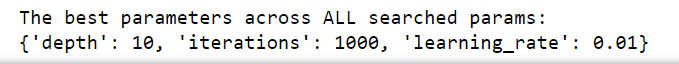

# Modeling

In [73]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(task_type="GPU",devices='0:1', loss_function='MAE', verbose=True)
model.fit(X, y)
y_preds = model.predict(df_test)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 13.5944229	total: 39.6ms	remaining: 39.6s
1:	learn: 13.3210600	total: 76.9ms	remaining: 38.4s
2:	learn: 13.0656606	total: 114ms	remaining: 38s
3:	learn: 12.8193866	total: 152ms	remaining: 37.9s
4:	learn: 12.5846566	total: 197ms	remaining: 39.3s
5:	learn: 12.3523853	total: 244ms	remaining: 40.4s
6:	learn: 12.1286575	total: 288ms	remaining: 40.9s
7:	learn: 11.9151684	total: 327ms	remaining: 40.6s
8:	learn: 11.7074402	total: 367ms	remaining: 40.4s
9:	learn: 11.5054775	total: 405ms	remaining: 40.1s
10:	learn: 11.3130879	total: 443ms	remaining: 39.8s
11:	learn: 11.1270482	total: 485ms	remaining: 39.9s
12:	learn: 10.9475092	total: 527ms	remaining: 40s
13:	learn: 10.7798866	total: 566ms	remaining: 39.9s
14:	learn: 10.6152138	total: 604ms	remaining: 39.7s
15:	learn: 10.4580125	total: 642ms	remaining: 39.5s
16:	learn: 10.3070090	total: 681ms	remaining: 39.4s
17:	learn: 10.1640437	total: 724ms	remaining: 39.5s
18:	learn: 10.0243934	total: 762ms	remaining: 39.4s
19:	learn: 9.8905924	tot

165:	learn: 6.7977110	total: 6.67s	remaining: 33.5s
166:	learn: 6.7966372	total: 6.71s	remaining: 33.5s
167:	learn: 6.7957866	total: 6.75s	remaining: 33.5s
168:	learn: 6.7949201	total: 6.8s	remaining: 33.4s
169:	learn: 6.7940136	total: 6.84s	remaining: 33.4s
170:	learn: 6.7929097	total: 6.88s	remaining: 33.3s
171:	learn: 6.7921121	total: 6.92s	remaining: 33.3s
172:	learn: 6.7912616	total: 6.96s	remaining: 33.3s
173:	learn: 6.7906454	total: 7.01s	remaining: 33.3s
174:	learn: 6.7897448	total: 7.04s	remaining: 33.2s
175:	learn: 6.7887622	total: 7.08s	remaining: 33.2s
176:	learn: 6.7879240	total: 7.13s	remaining: 33.1s
177:	learn: 6.7874404	total: 7.17s	remaining: 33.1s
178:	learn: 6.7867819	total: 7.21s	remaining: 33.1s
179:	learn: 6.7857840	total: 7.25s	remaining: 33s
180:	learn: 6.7851167	total: 7.29s	remaining: 33s
181:	learn: 6.7840605	total: 7.33s	remaining: 32.9s
182:	learn: 6.7832924	total: 7.37s	remaining: 32.9s
183:	learn: 6.7828589	total: 7.42s	remaining: 32.9s
184:	learn: 6.782

327:	learn: 6.7290321	total: 13.3s	remaining: 27.3s
328:	learn: 6.7288843	total: 13.4s	remaining: 27.3s
329:	learn: 6.7287506	total: 13.4s	remaining: 27.2s
330:	learn: 6.7286198	total: 13.4s	remaining: 27.2s
331:	learn: 6.7284926	total: 13.5s	remaining: 27.1s
332:	learn: 6.7284001	total: 13.5s	remaining: 27.1s
333:	learn: 6.7282852	total: 13.6s	remaining: 27s
334:	learn: 6.7282181	total: 13.6s	remaining: 27s
335:	learn: 6.7281062	total: 13.6s	remaining: 27s
336:	learn: 6.7279954	total: 13.7s	remaining: 26.9s
337:	learn: 6.7278299	total: 13.7s	remaining: 26.9s
338:	learn: 6.7277198	total: 13.8s	remaining: 26.8s
339:	learn: 6.7276249	total: 13.8s	remaining: 26.8s
340:	learn: 6.7275548	total: 13.8s	remaining: 26.8s
341:	learn: 6.7275030	total: 13.9s	remaining: 26.7s
342:	learn: 6.7274600	total: 13.9s	remaining: 26.7s
343:	learn: 6.7273958	total: 14s	remaining: 26.6s
344:	learn: 6.7272974	total: 14s	remaining: 26.6s
345:	learn: 6.7272332	total: 14.1s	remaining: 26.6s
346:	learn: 6.7270954	

490:	learn: 6.7161298	total: 20.1s	remaining: 20.8s
491:	learn: 6.7160119	total: 20.1s	remaining: 20.8s
492:	learn: 6.7158523	total: 20.2s	remaining: 20.7s
493:	learn: 6.7157404	total: 20.2s	remaining: 20.7s
494:	learn: 6.7156379	total: 20.2s	remaining: 20.7s
495:	learn: 6.7154942	total: 20.3s	remaining: 20.6s
496:	learn: 6.7153404	total: 20.3s	remaining: 20.6s
497:	learn: 6.7152220	total: 20.4s	remaining: 20.5s
498:	learn: 6.7150783	total: 20.4s	remaining: 20.5s
499:	learn: 6.7148227	total: 20.5s	remaining: 20.5s
500:	learn: 6.7146919	total: 20.5s	remaining: 20.4s
501:	learn: 6.7145823	total: 20.5s	remaining: 20.4s
502:	learn: 6.7144763	total: 20.6s	remaining: 20.3s
503:	learn: 6.7143667	total: 20.6s	remaining: 20.3s
504:	learn: 6.7142501	total: 20.7s	remaining: 20.3s
505:	learn: 6.7140116	total: 20.7s	remaining: 20.2s
506:	learn: 6.7139638	total: 20.7s	remaining: 20.2s
507:	learn: 6.7138684	total: 20.8s	remaining: 20.1s
508:	learn: 6.7137783	total: 20.8s	remaining: 20.1s
509:	learn: 

651:	learn: 6.7076204	total: 27.1s	remaining: 14.5s
652:	learn: 6.7076063	total: 27.2s	remaining: 14.4s
653:	learn: 6.7075986	total: 27.2s	remaining: 14.4s
654:	learn: 6.7075144	total: 27.3s	remaining: 14.4s
655:	learn: 6.7074785	total: 27.3s	remaining: 14.3s
656:	learn: 6.7074620	total: 27.4s	remaining: 14.3s
657:	learn: 6.7074567	total: 27.4s	remaining: 14.2s
658:	learn: 6.7074537	total: 27.4s	remaining: 14.2s
659:	learn: 6.7074490	total: 27.5s	remaining: 14.2s
660:	learn: 6.7074449	total: 27.5s	remaining: 14.1s
661:	learn: 6.7074367	total: 27.6s	remaining: 14.1s
662:	learn: 6.7074343	total: 27.6s	remaining: 14s
663:	learn: 6.7074249	total: 27.6s	remaining: 14s
664:	learn: 6.7074172	total: 27.7s	remaining: 13.9s
665:	learn: 6.7073719	total: 27.7s	remaining: 13.9s
666:	learn: 6.7073359	total: 27.8s	remaining: 13.9s
667:	learn: 6.7073035	total: 27.8s	remaining: 13.8s
668:	learn: 6.7072982	total: 27.8s	remaining: 13.8s
669:	learn: 6.7072823	total: 27.9s	remaining: 13.7s
670:	learn: 6.70

811:	learn: 6.7041692	total: 34.1s	remaining: 7.9s
812:	learn: 6.7041657	total: 34.2s	remaining: 7.86s
813:	learn: 6.7041575	total: 34.2s	remaining: 7.82s
814:	learn: 6.7041280	total: 34.2s	remaining: 7.77s
815:	learn: 6.7041239	total: 34.3s	remaining: 7.73s
816:	learn: 6.7040968	total: 34.3s	remaining: 7.69s
817:	learn: 6.7040090	total: 34.4s	remaining: 7.65s
818:	learn: 6.7039313	total: 34.4s	remaining: 7.6s
819:	learn: 6.7038947	total: 34.4s	remaining: 7.56s
820:	learn: 6.7038765	total: 34.5s	remaining: 7.52s
821:	learn: 6.7038565	total: 34.5s	remaining: 7.48s
822:	learn: 6.7038523	total: 34.6s	remaining: 7.43s
823:	learn: 6.7038223	total: 34.6s	remaining: 7.39s
824:	learn: 6.7038111	total: 34.7s	remaining: 7.35s
825:	learn: 6.7037981	total: 34.7s	remaining: 7.31s
826:	learn: 6.7037687	total: 34.7s	remaining: 7.27s
827:	learn: 6.7034624	total: 34.8s	remaining: 7.22s
828:	learn: 6.7034530	total: 34.8s	remaining: 7.18s
829:	learn: 6.7034447	total: 34.9s	remaining: 7.14s
830:	learn: 6.

974:	learn: 6.7007799	total: 41.2s	remaining: 1.06s
975:	learn: 6.7007074	total: 41.3s	remaining: 1.01s
976:	learn: 6.7007104	total: 41.3s	remaining: 973ms
977:	learn: 6.7007021	total: 41.4s	remaining: 931ms
978:	learn: 6.7006697	total: 41.4s	remaining: 888ms
979:	learn: 6.7006615	total: 41.5s	remaining: 846ms
980:	learn: 6.7006591	total: 41.5s	remaining: 804ms
981:	learn: 6.7006491	total: 41.6s	remaining: 762ms
982:	learn: 6.7006438	total: 41.6s	remaining: 720ms
983:	learn: 6.7006373	total: 41.7s	remaining: 677ms
984:	learn: 6.7006297	total: 41.7s	remaining: 635ms
985:	learn: 6.7006038	total: 41.7s	remaining: 593ms
986:	learn: 6.7005720	total: 41.8s	remaining: 550ms
987:	learn: 6.7005720	total: 41.8s	remaining: 508ms
988:	learn: 6.7005672	total: 41.9s	remaining: 466ms
989:	learn: 6.7005631	total: 41.9s	remaining: 423ms
990:	learn: 6.7005625	total: 42s	remaining: 381ms
991:	learn: 6.7005513	total: 42s	remaining: 339ms
992:	learn: 6.7005508	total: 42s	remaining: 296ms
993:	learn: 6.7005

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

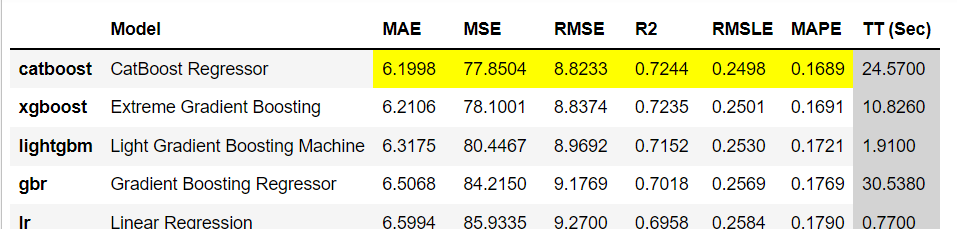

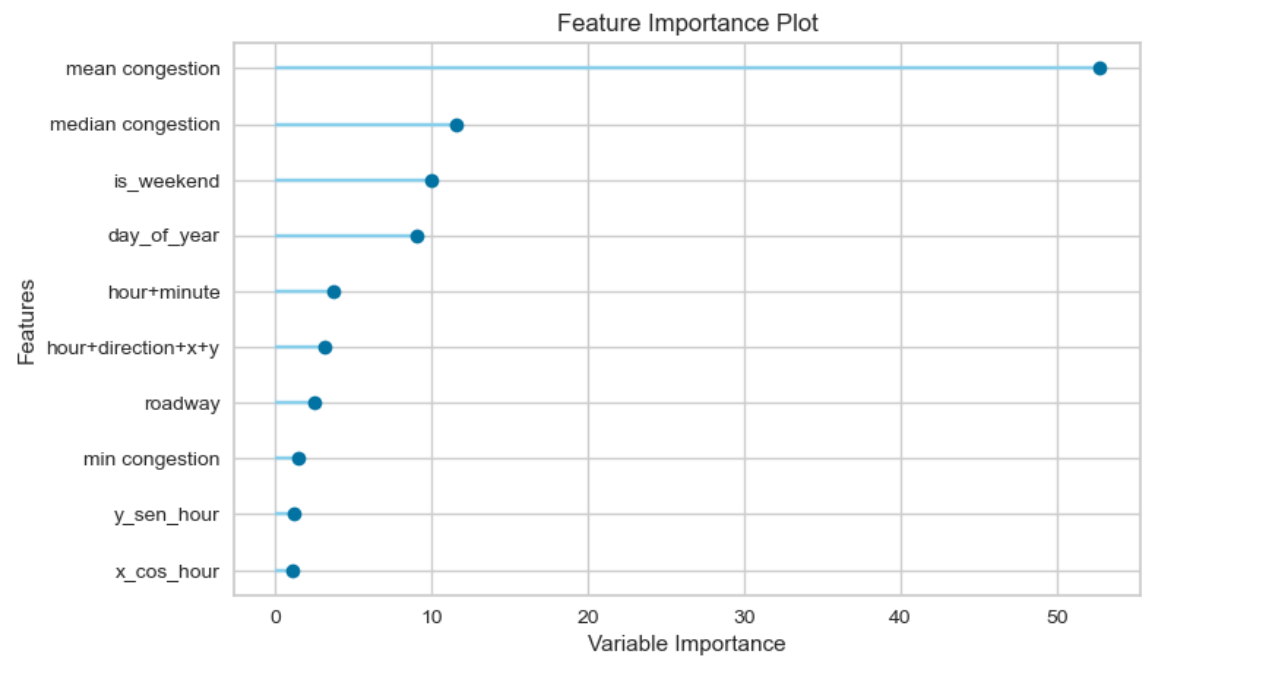

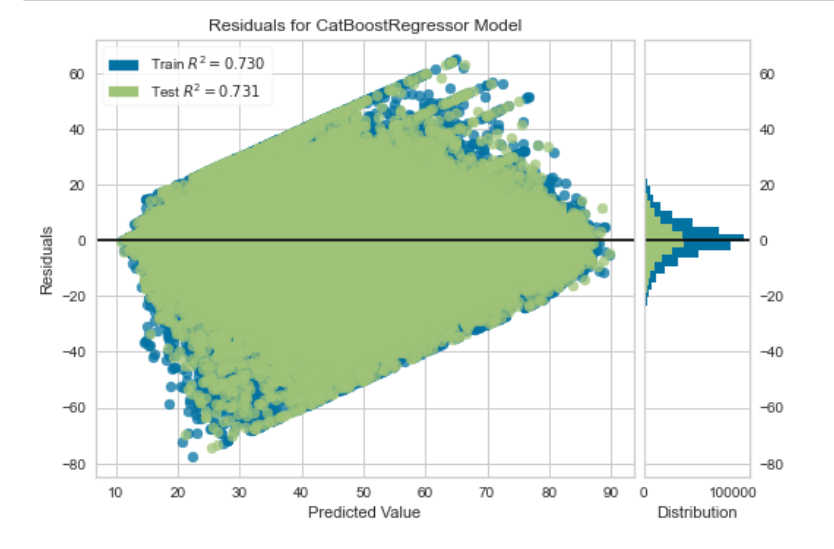

In [ ]:
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

y_probs = []
y_probs_final = []

folds = StratifiedKFold(n_splits = 20, shuffle=True)
for fold, (train_id, test_id) in enumerate(folds.split(X, y)):
    print("fold : ", fold + 1, end = ' ')
    # Split data
    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]

    # Train RF
    #model =  RandomForestRegressor(n_jobs=-1)
    model = CatBoostRegressor(depth=10,task_type="GPU",devices='0:1', loss_function='MAE', verbose=False)
    model.fit(X_train, y_train)

    # Print validation score to see how it works
    valid_pred = model.predict(X_valid)
    valid_mae = mean_absolute_error(y_valid, valid_pred)
    print( "Validation MAE: ", valid_mae, end = ' ')

    # test
    y_probs.append(model.predict(df_test))
    print(" ")
    
y_probs_final = sum(y_probs) / len(y_probs)

In [ ]:
y_probs

In [ ]:
y_probs_final

# Submission

In [ ]:
sub.head(2)

In [ ]:
def save_submission(y_pred):  
    #classes = label.inverse_transform(y_pred)
    sub["congestion"] = y_pred
    #assert len(classes) == sub.shape[0]
    assert 2 == sub.shape[1]   
    sub.to_csv("E:/downloads/sample_submission.csv", index=False)
    return sub

save_submission(y_preds).head(3)